In [ ]:
!pip install chromadb --quiet
!pip install open_clip_torch --quiet

In [ ]:
!unzip /content/drive/MyDrive/AIO-2024/data.zip -d data

In [49]:
import os
from tqdm import tqdm
from PIL import Image
import numpy as np
import chromadb
import json
import time
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction
embedding_function = OpenCLIPEmbeddingFunction()

In [6]:
ROOT = 'data/data/'
CLASS_NAME = sorted(list(os.listdir(f'{ROOT}/train')))

def get_files_path(path):
    files_path = []
    for label in CLASS_NAME:
        label_path = path + "/" + label
        filenames = os.listdir(label_path)
        for filename in filenames:
            filepath = label_path + '/' + filename
            files_path.append(filepath)
    return files_path

data_path = f'{ROOT}/train'
files_path = get_files_path(path=data_path)

def get_single_image_embedding(image):
    embedding = embedding_function._encode_image(image=image)
    return np.array(embedding)

def add_embedding(files_path):
  ids = []
  embeddings = []
  mapping_path = {}

  for id_filepath, filepath in tqdm(enumerate(files_path)):
    ids.append(f'id_{id_filepath}')
    image = Image.open(filepath)
    image = np.array(image)
    embedding = get_single_image_embedding(image=image)
    embeddings.append(embedding)
    mapping_path[f'id_{id_filepath}'] = filepath
  return embeddings,ids, mapping_path

In [7]:
def save_collection_data(ids, embeddings,mapping_paths, save_path):
  if not os.path.exists(save_path):
    os.makedirs(save_path)

  embeddings_path = os.path.join(save_path, 'embeddings.npy')
  np.save(embeddings_path, embeddings)

  ids_path = os.path.join(save_path, 'ids.json')
  with open(ids_path, 'w') as ids_file:
    json.dump(ids, ids_file)

  files_path = os.path.join(save_path, 'mapping_paths.json')
  with open(files_path, 'w') as path_file:
    json.dump(mapping_paths, path_file)

In [8]:
embeddings,ids,mapping_paths = add_embedding(files_path = files_path)

595it [02:29,  3.99it/s]


In [11]:
embeddings=[x.tolist() for x in embeddings]

In [12]:
HNSW_SPACE = "hnsw:space"
save_path = 'collection'
save_collection_data(ids,embeddings,mapping_paths, save_path)

## Load the collection

In [13]:
def load_collection_data(client, collection_name,meta_name, load_path):
  # Load the ids from the .json file
  ids_path = os.path.join(load_path, 'ids.json')
  with open(ids_path, 'r') as ids_file:
    ids = json.load(ids_file)

  # Load the paths from the .json file
  mapping_paths = os.path.join(load_path, 'mapping_paths.json')
  with open(mapping_paths, 'r') as paths_file:
    mapping = json.load(paths_file)

  # Load the embeddings from the .npy file
  embeddings_path = os.path.join(load_path, 'embeddings.npy')
  embeddings = np.load(embeddings_path, allow_pickle=True)

  # Get or create the collection in ChromaDB
  collection = client.get_or_create_collection( name = collection_name,
                                                      metadata={HNSW_SPACE: meta_name})
  # Add the embeddings and ids back to the collection
  collection.add(
    embeddings=embeddings.tolist(),
    ids=ids)

  return collection, mapping

In [ ]:
ids_path = os.path.join('collection', 'ids.json')
with open(ids_path, 'r') as ids_file:
  ids = json.load(ids_file)

# Load the paths from the .json file
mapping_paths = os.path.join('collection', 'mapping_paths.json')
with open(mapping_paths, 'r') as paths_file:
  mapping = json.load(paths_file)

# Load the embeddings from the .npy file
embeddings_path = os.path.join('collection', 'embeddings.npy')
embeddings = np.load(embeddings_path, allow_pickle=True)

client = chromadb.Client()
l2_loaded_collection = client.get_or_create_collection( name = 'l2_collection',
                                                      metadata={HNSW_SPACE: "l2"})
l2_loaded_collection.add(
    embeddings=embeddings.tolist(),
    ids=ids)

client = chromadb.Client()
cosine_loaded_collection = client.get_or_create_collection( name = 'cosine_collection',
                                                      metadata={HNSW_SPACE: "cosine"})
cosine_loaded_collection.add(
    embeddings=embeddings.tolist(),
    ids=ids)

## Create Search Engine

In [32]:
def search(image_path, collection, n_results):
  query_image = Image.open(image_path)
  query_image = np.array(query_image)
  query_embedding = get_single_image_embedding(query_image)
  results = collection.query(
    query_embeddings=[query_embedding.tolist()],
    n_results=n_results
  )
  return results

## Query by l2

In [54]:
test_path = f'{ROOT}/test'
test_files_path = get_files_path(path=test_path)
test_path = test_files_path[1]
print(test_path)
t0 =time.time()
l2_results = search(image_path = test_path, collection = l2_loaded_collection, n_results=5)
print(f'Time Process: {time.time()  - t0} (seconds)')
print(l2_results)

data/data//test/American_egret/n02009912_2473.JPEG
Time Process: 0.35951972007751465 (second)
{'ids': [['id_13', 'id_11', 'id_19', 'id_12', 'id_15']], 'distances': [[0.40494874119758606, 0.4122699201107025, 0.5080230832099915, 0.5198448896408081, 0.5294203758239746]], 'metadatas': [[None, None, None, None, None]], 'embeddings': None, 'documents': [[None, None, None, None, None]], 'uris': None, 'data': None, 'included': ['metadatas', 'documents', 'distances']}


In [36]:
mapping['id_101']

'data/data//train/basketball/n02802426_24958.JPEG'

In [37]:
import matplotlib.pyplot as plt
def plot_results(image_path, files_path, results):
  query_image = Image.open(image_path)

  mapping_paths_results = []
  for id in results['ids'][0]  :
      mapping_paths_results.append(mapping[id])

  # Calculate number of Columns and number of Rows
  n_results = len(mapping_paths_results)
  grid_size = int(np.ceil(np.sqrt(n_results + 1)))  # Adding 1 for query image

  plt.figure(figsize=(grid_size * 5, grid_size * 5))
  plt.subplot(grid_size, grid_size, 1)
  plt.imshow(query_image)
  plt.title("Query Image")
  plt.axis('off')

  # Results Ploting
  for i, result_file in enumerate(mapping_paths_results):
      plt.subplot(grid_size, grid_size, i + 2)
      result_image = Image.open(result_file)
      plt.imshow(result_image)
      plt.title(f"Result {i + 1}")
      plt.axis('off')
  plt.show()

In [ ]:
l2_results['ids'][0]

['id_13', 'id_11', 'id_19', 'id_12', 'id_15']

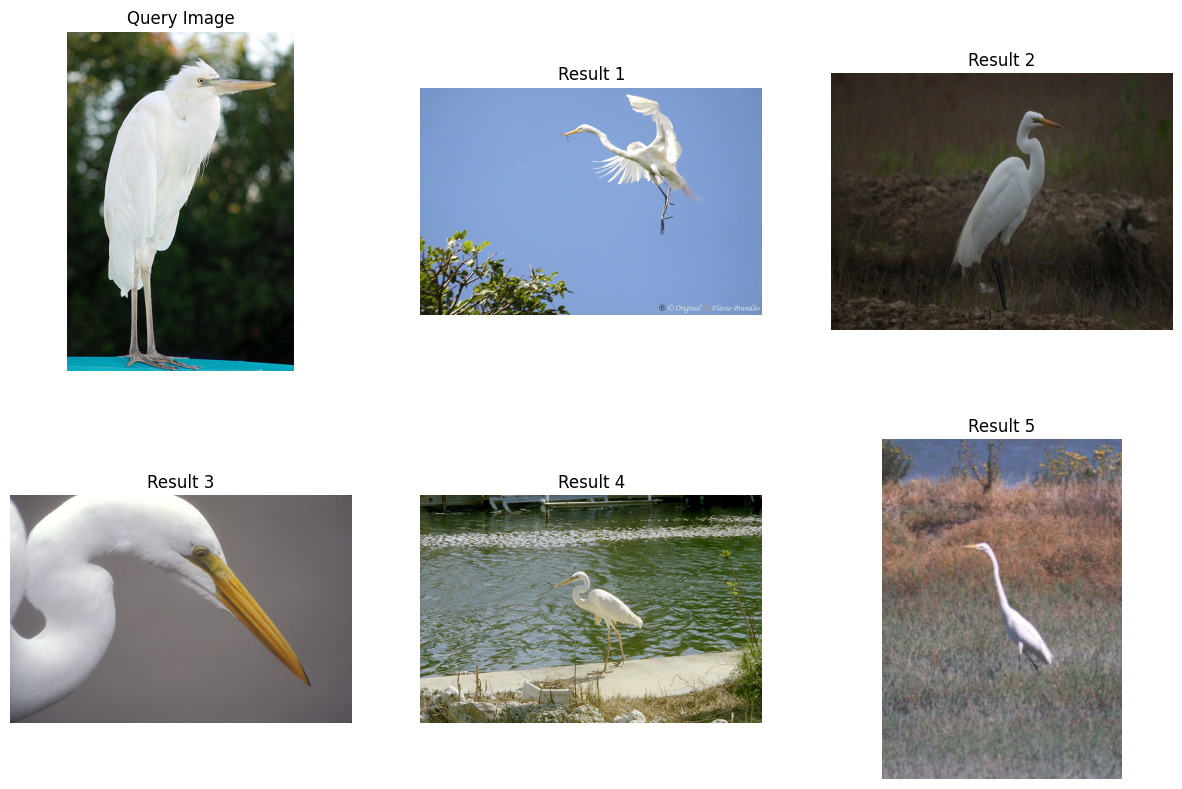

In [38]:
plot_results(image_path=test_path, files_path=files_path, results=l2_results)

## Query by cosine

In [56]:
test_path = f'{ROOT}/test'
test_files_path = get_files_path(path=test_path)
test_path = test_files_path[4]
print(test_path)
t0 = time.time()
cosine_results = search(image_path = test_path, collection = cosine_loaded_collection, n_results=5)
print(f'Time Process: {time.time() - t0} (seconds)')
print(cosine_results)

data/data//test/Orange_easy/0_100.jpg
Time Process: 0.3792538642883301 (seconds)
{'ids': [['id_40', 'id_41', 'id_42', 'id_44', 'id_43']], 'distances': [[0.029111921787261963, 0.049443185329437256, 0.056821584701538086, 0.058405935764312744, 0.13564038276672363]], 'metadatas': [[None, None, None, None, None]], 'embeddings': None, 'documents': [[None, None, None, None, None]], 'uris': None, 'data': None, 'included': ['metadatas', 'documents', 'distances']}


In [57]:
cosine_results['ids'][0]

['id_40', 'id_41', 'id_42', 'id_44', 'id_43']

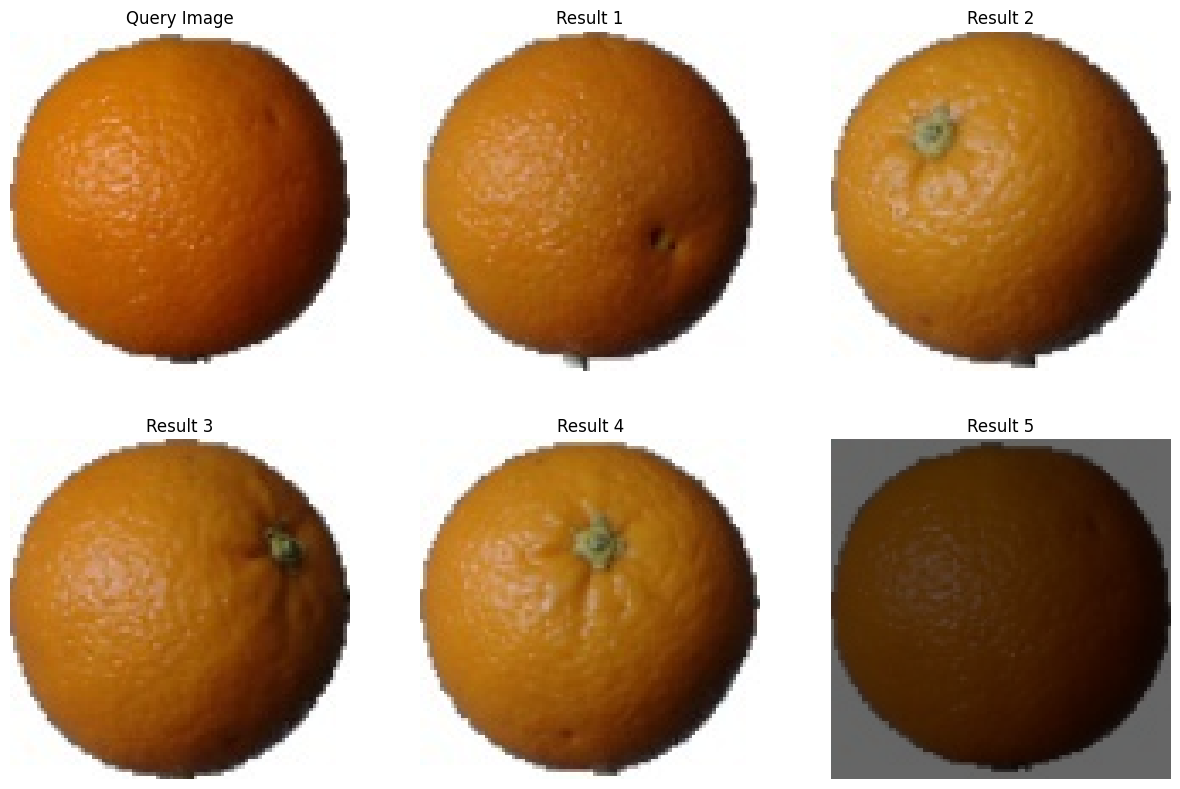

In [58]:
plot_results(image_path = test_path, files_path = files_path, results = cosine_results)